# Laserkøling Simulation

In [1]:
import matplotlib.pyplot as plt
import numpy as np

I simulationen antager jeg at zeemaneffekten allerede tager sted og at atomet også kan absorbere en foton mens den er i sit exiteret stat, så at jo længe atomet bevæger sig imod laseren, vil alle fotoner blive absorberet

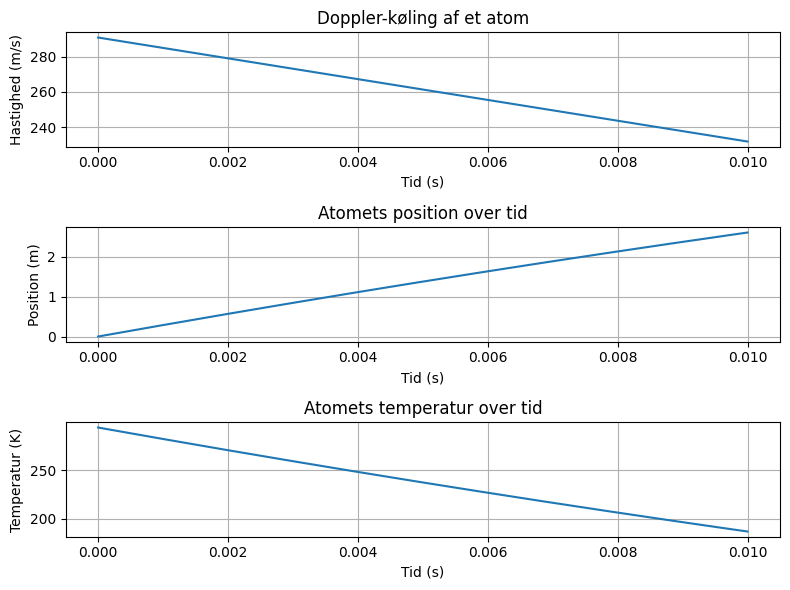

In [2]:
# Fysiske konstanter
mass = 1.44e-25  # Masse af atomet (ca. for et Rubidium-87 atom) i kg
h = 6.62606876e-34
hbar = h/2*np.pi  # Plancks reducerede konstant
k_B = 1.38e-23  # Boltzmanns konstant
Lambda = 780e-9
p_foton = -h/Lambda
T_start = 21 + 273.15 # Start temperatur i K

initial_velocity = np.sqrt((3*k_B*T_start)/mass) # Starthastighed i m/s

def simulate_motion(dt=1e-6, steps=10000):
    """Simulerer atomets bevægelse over tid med en start hastighed."""
    v = np.zeros(steps)
    x = np.zeros(steps)
    t = np.zeros(steps)
    v[0] = initial_velocity  # Start med en initial hastighed
    t[0] = T_start
    
    for i in range(1, steps):
        v[i] = v[i-1] + p_foton/mass
        x[i] = x[i-1] + v[i] * dt
        t[i] = (2/3) * 0.5*mass*v[i]**2 / k_B
    
    return x, v, t

# Kør simuleringen med en start hastighed
x_vals, v_vals, t_vals = simulate_motion()

time = np.linspace(0, len(v_vals) * 1e-6, len(v_vals))

# Plot resultaterne
fig, ax = plt.subplots(3, 1, figsize=(8, 6))
ax[0].plot(time, v_vals)
ax[0].set_xlabel("Tid (s)")
ax[0].set_ylabel("Hastighed (m/s)")
ax[0].set_title("Doppler-køling af et atom")
ax[0].grid()

ax[1].plot(time, x_vals)
ax[1].set_xlabel("Tid (s)")
ax[1].set_ylabel("Position (m)")
ax[1].set_title("Atomets position over tid")
ax[1].grid()

ax[2].plot(time, t_vals)
ax[2].set_xlabel("Tid (s)")
ax[2].set_ylabel("Temperatur (K)")
ax[2].set_title("Atomets temperatur over tid")
ax[2].grid()

plt.tight_layout()
plt.show()

# Simulation med udgangspunkt i MP's tegning

Brugt data fra [denne side](https://steck.us/alkalidata/rubidium87numbers.1.6.pdf#page=15).
Her er der igen antagelsen om, at vi har en ændrene magnetfelt
Men her bliver alle fotoner optaget, så længe, atomet ikke er i en exiteret tilstand

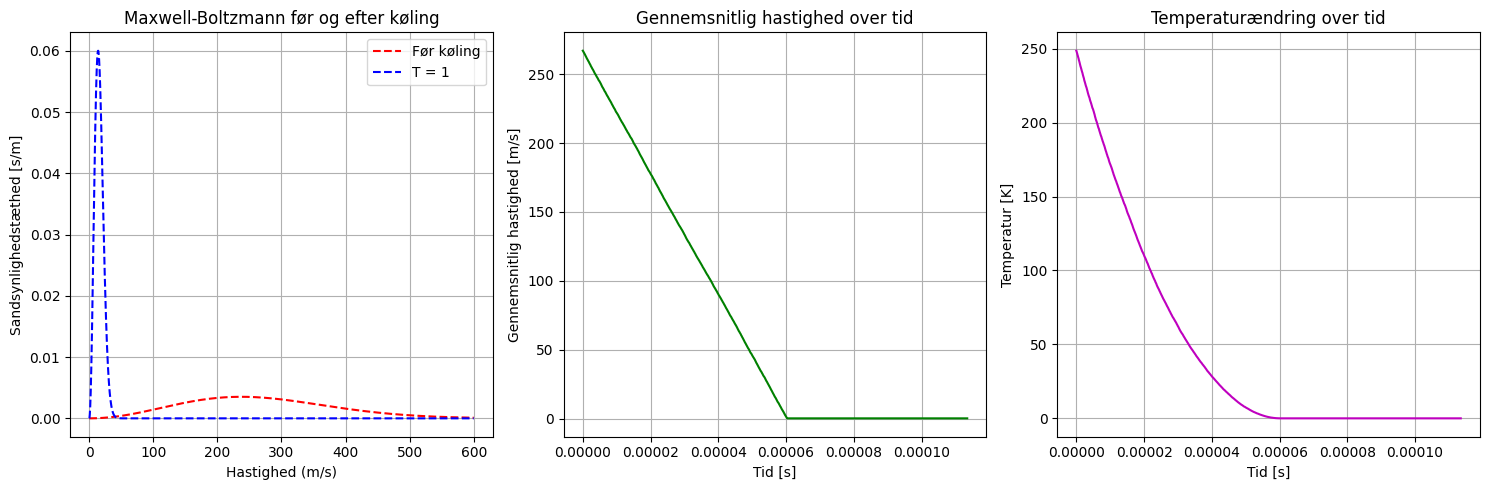

In [27]:
import numpy as np
from numpy import random
import matplotlib.pyplot as plt

# Konstanter
k_B = 1.38e-23 # Boltzmanns konstant (J/K)
h = 6.626e-34 # Plancks konstant (J·s)
hbar = h/2*np.pi # Planks reduceret konstnt (J·s)
m = 1.443e-25 # Masse af et Rb87 atom (kg)
T = 21 + 273.15 # Temperatur (K)
lambda_laser = 461e-9  # Laserbølgelængde (m)
c = 3e8 # Lysets hastighed (m/s)
tau = 2.27e-9 # Levetid i exiterede tilstand (s)
Gamma = 3.610e7 # Naturlig linjebredde (Hz)
TD = 146e-6 # Doppler limit (K)
v_min = np.sqrt((3*k_B*TD)/m)

p_foton = h / lambda_laser  # Bevægelsesmængde af en foton (kg·m/s)

# Maxwell-Boltzmann fordeling af hastigheder
def maxwell_boltzmann(v, T, m):
    return (m / (2 * np.pi * k_B * T))**(3/2) * 4 * np.pi * v**2 * np.exp(-m * v**2 / (2 * k_B * T))

# Beregning af temperatur
def calculate_temperature(v_atoms):
    return (m * (np.mean(v_atoms)**2) / (3 * k_B))


v_vals = np.linspace(0, 600, 10000)  # Hastighedsinterval i m/s
prob_vals = maxwell_boltzmann(v_vals, T, m)
prob_vals /= np.trapezoid(prob_vals, v_vals)  # Normalisering af fordelingen
#prob_vals = prob_vals*100 # Omregner til procent

# Doppler-skift og laserkøling
v_atoms = np.random.choice(v_vals, size=10000, p=prob_vals/np.sum(prob_vals))

# Iterer kølingsprocessen
num_steps = 50000
mean_v = []
temperatures = []

for steps in range(num_steps):
    # Påvirkning fra fotonens bevægelsesmængde
    Delta_v = p_foton / m  # Hastighedsændring pr. foton
    v_atoms -= Delta_v  # Ændingen i hastighed ved absorption

    # Tilfældig emission (ensartet i alle retninger)
    direction = random.choice([-1,1]) # Bestemmer en tilfældig retning, hvor -1 er fremad, og 1 er tilbage
    if direction == 1:
        v_atoms -= Delta_v
    else:
        v_atoms += Delta_v

    if np.mean(v_atoms) > v_min:
        mean_v.append(np.mean(v_atoms))
        temperature = calculate_temperature(v_atoms) # Beregn temperatur
        temperatures.append(temperature)
    else:
        temperatures.append(TD)
        mean_v.append(v_min)
    
time = np.linspace(0, len(mean_v) * tau, len(mean_v))

# Finder Maxwell-Bosemann fordelingen for atomerne ved dens sluttemperatur
NT = temperatures[-1]
Nprob_vals = maxwell_boltzmann(v_vals, 1, m)
Nprob_vals /= np.trapezoid(Nprob_vals, v_vals)  # Normalisering af fordelingen
#Nprob_vals = Nprob_vals*100 # Omregner til procent

# Plot resultatet
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
# plt.hist(v_atoms, bins=50, density=True, alpha=0.7, color='blue', label='Efter køling')
plt.plot(v_vals, prob_vals, 'r--', label='Før køling')
plt.plot(v_vals, Nprob_vals, 'b--', label='T = 1')
plt.xlabel('Hastighed (m/s)')
plt.ylabel('Sandsynlighedstæthed [s/m]')
plt.legend()
plt.title('Maxwell-Boltzmann før og efter køling')
plt.grid()

plt.subplot(1, 3, 2)
plt.plot(time, mean_v, 'g-')
plt.xlabel('Tid [s]')
plt.ylabel('Gennemsnitlig hastighed [m/s]')
plt.title('Gennemsnitlig hastighed over tid')
plt.grid()

plt.subplot(1, 3, 3)
plt.plot(time, temperatures, 'm-')
plt.xlabel('Tid [s]')
plt.ylabel('Temperatur [K]')
plt.title('Temperaturændring over tid')
plt.grid()

plt.tight_layout()
plt.show()

